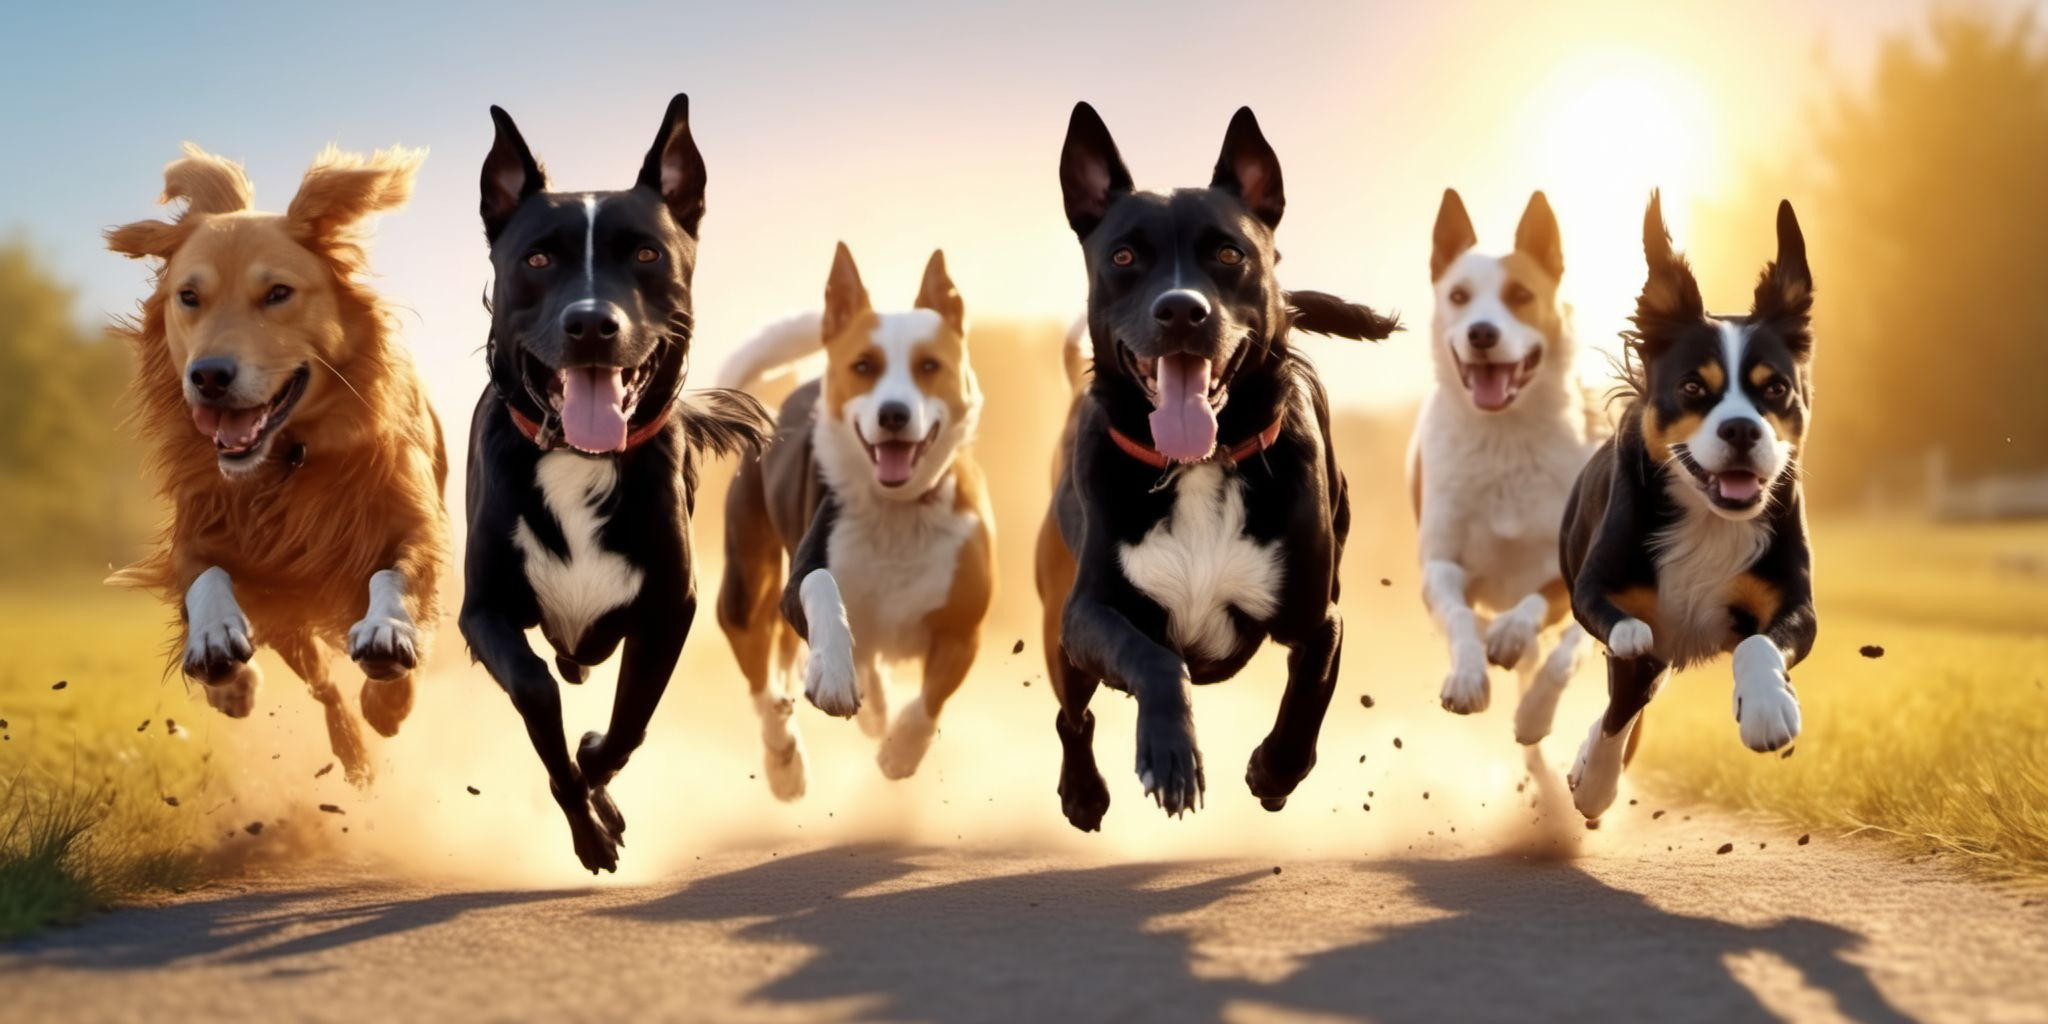

# Global AI Hub 120 Dog Breed Classification Project

# Imports and Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_47/1355298896.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
train = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
train_dir = "/kaggle/input/dog-breed-identification/train"
test_dir = "/kaggle/input/dog-breed-identification/test"

In [3]:
train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Data Preprocessing


In [4]:
def get_features(model_name, data_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [6]:
dog_breeds = sorted(list(set(train['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:5]

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [7]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [8]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    y = to_categorical(y)
    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Output Data Size: ', X.shape)
    print('Output Label Size: ', y.shape)
    return X, y

In [9]:
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
from keras.utils import to_categorical


img_size = (224,224, 3)
X, y = images_to_array(train_dir, train, img_size)

100%|██████████| 10222/10222 [00:22<00:00, 451.63it/s]


Output Data Size:  (10222, 224, 224, 3)
Output Label Size:  (10222, 120)


In [10]:
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)



160/160 [==============================] - 28s 119ms/step
Feature maps shape:  (10222, 2048)


In [11]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)


160/160 [==============================] - 41s 235ms/step
Feature maps shape:  (10222, 2048)


In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
mobilenet_v2_preprocessor = preprocess_input
mobilenet_v2_features = get_features(MobileNetV2,
                                   mobilenet_v2_preprocessor,
                                   img_size, X)

160/160 [==============================] - 13s 71ms/step
Feature maps shape:  (10222, 1280)


In [13]:
del X

In [14]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 mobilenet_v2_features], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 5376)


Splitting the dataset

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(final_features, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Normalize pixel values

In [16]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Building a Model

In [17]:
from keras.callbacks import EarlyStopping
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


model = models.Sequential([
    InputLayer(X_train.shape[1:]),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 128)               688256    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               15480     
                                                                 
Total params: 703736 (2.68 MB)
Trainable params: 703736 (2.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [19]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=my_callback, batch_size=128)

Epoch 1/20
64/64 [==============================] - 2s 8ms/step - loss: 4.7346 - accuracy: 0.1068 - val_loss: 4.6546 - val_accuracy: 0.3170
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 4.4951 - accuracy: 0.2660 - val_loss: 4.3109 - val_accuracy: 0.3307
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 4.0154 - accuracy: 0.3167 - val_loss: 3.7052 - val_accuracy: 0.4374
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 3.3593 - accuracy: 0.4075 - val_loss: 2.9848 - val_accuracy: 0.5734
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 2.7272 - accuracy: 0.5024 - val_loss: 2.3632 - val_accuracy: 0.6605
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 2.2472 - accuracy: 0.5624 - val_loss: 1.9031 - val_accuracy: 0.7260
Epoch 7/20
64/64 [==============================] - 0s 5ms/step - loss: 1.8957 - accuracy: 0.6186 - val_loss: 1.5753 - val_accuracy: 0.7691
Epoch 8/20
64/64 [==

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

32/32 [==============================] - 0s 3ms/step - loss: 0.7205 - accuracy: 0.7869
Test Accuracy: 78.69%
Test Loss: 0.7205


### Plot training history

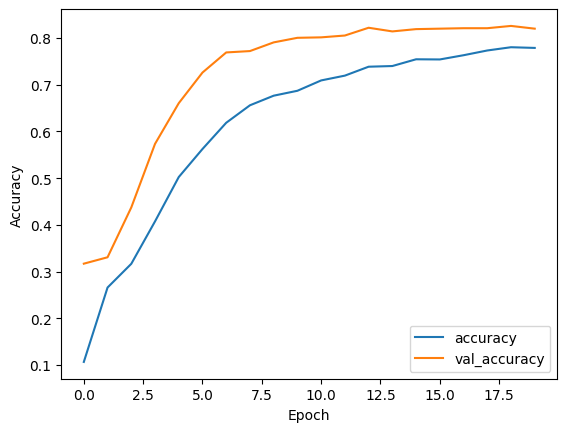

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

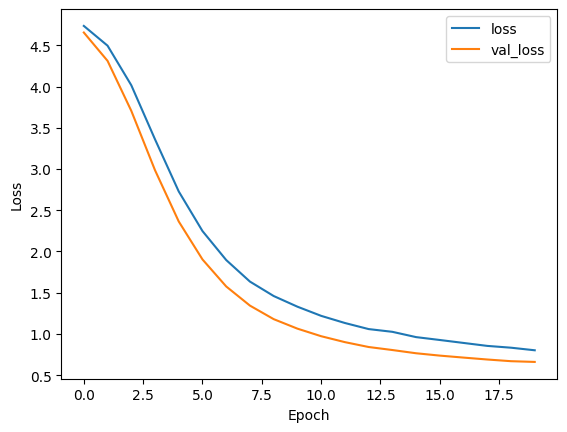

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Hyper-parameter Optimization

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

def build_model(hp):
    model = models.Sequential([
    InputLayer(X_train.shape[1:]),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
    layers.Dense(n_classes, activation='softmax'),
    
])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=1, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='hyperparameter_optimization',
    project_name='dog_breed_classification'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


print("Best Hyperparameters:", best_hyperparameters)

history = best_model.fit(X_train, y_train,
            batch_size=128,
            epochs=20,
            validation_data=(X_val, y_val),
            callbacks=my_callback)

Trial 20 Complete [00h 00m 21s]
val_accuracy: 0.8375734090805054

Best val_accuracy So Far: 0.8473581075668335
Total elapsed time: 00h 07m 01s
Best Hyperparameters: {'dropout': 0.5, 'learning_rate': 0.0026246640749948364}
Epoch 1/20
64/64 [==============================] - 1s 8ms/step - loss: 0.5422 - accuracy: 0.8328 - val_loss: 0.4821 - val_accuracy: 0.8483
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 0.5204 - accuracy: 0.8383 - val_loss: 0.4812 - val_accuracy: 0.8493
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 0.5200 - accuracy: 0.8407 - val_loss: 0.4803 - val_accuracy: 0.8493
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 0.5058 - accuracy: 0.8416 - val_loss: 0.4811 - val_accuracy: 0.8493
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 0.4994 - accuracy: 0.8435 - val_loss: 0.4782 - val_accuracy: 0.8503
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 0.5022

In [24]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

32/32 [==============================] - 0s 3ms/step - loss: 0.5627 - accuracy: 0.8192
Test Accuracy: 81.92%
Test Loss: 0.5627


### Plot training history

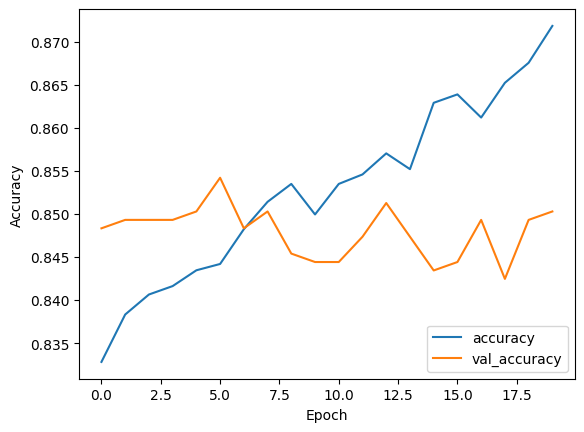

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Epoch 5-6 looks good.

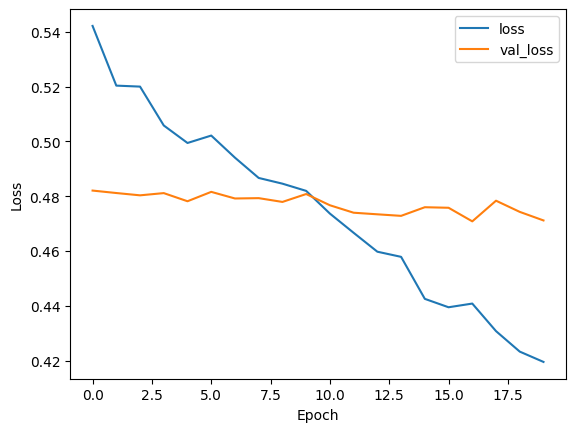

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

We could use Epoch 9 for our model.

# Creating a Submission File

In [27]:
sample_df = pd.read_csv("/kaggle/input/dog-breed-identification/sample_submission.csv")

In [28]:
import pandas as pd
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input

test_path = test_dir

def images_to_array_test(test_path, img_size = (224,224,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[ix]=img
        del img
    print('Output Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)



100%|██████████| 10357/10357 [01:36<00:00, 107.10it/s]

Output Data Size:  (10357, 224, 224, 3)


In [29]:
def extract_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    mobilenetv2_features = get_features(MobileNetV2, mobilenet_v2_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     mobilenetv2_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    del inception_features
    del xception_features
    del mobilenetv2_features
    
    return final_features

test_features = extract_features(test_data)

162/162 [==============================] - 21s 124ms/step
Feature maps shape:  (10357, 2048)
162/162 [==============================] - 40s 243ms/step
Feature maps shape:  (10357, 2048)
162/162 [==============================] - 12s 72ms/step
Feature maps shape:  (10357, 1280)
Final feature maps shape (10357, 5376)


In [30]:
pred = best_model.predict(test_features, batch_size=128)

81/81 [==============================] - 0s 2ms/step


In [31]:
preds_df = pd.DataFrame(columns=["id"] + dog_breeds)
preds_df.head()
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head
preds_df.loc[:,dog_breeds]= pred

preds_df.to_csv('submission_1.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f7a32505c12649183c5991ecfa7d68b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bc6d50ffb4644feb34530aa58943e85b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7cbc041e79135a572aad87904b5c9c57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f3b603f10d6a344f0395fb46b242ff8e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Saving the model

In [ ]:
best_model.save("best_model.h5")

loaded_model = keras.models.load_model("best_model.h5")

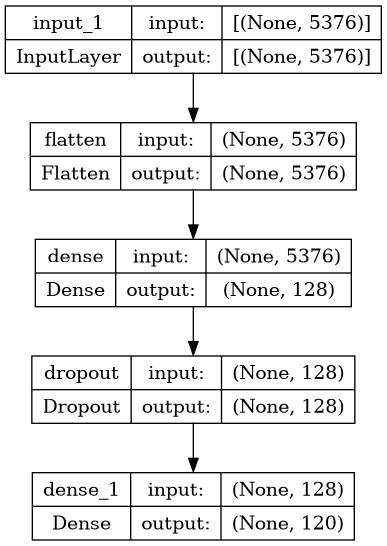

In [37]:
from keras.utils import plot_model

plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

32/32 [==============================] - 0s 2ms/step


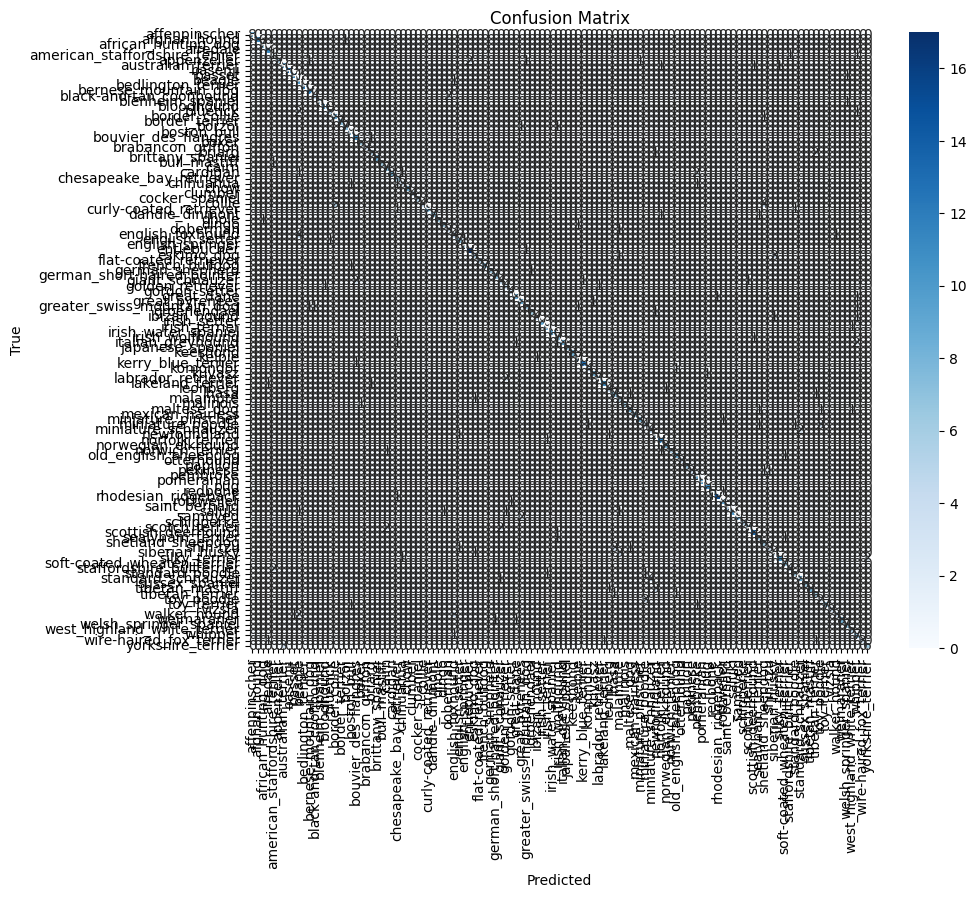

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dog_breeds, yticklabels=dog_breeds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()